# NetworKit User Guide

## About NetworKit

[NetworKit][networkit] is an open-source toolkit for high-performance
network analysis. Its aim is to provide tools for the analysis of large
networks in the size range from thousands to billions of edges. For this
purpose, it implements efficient graph algorithms, many of them parallel to
utilize multicore architectures. These are meant to compute standard measures
of network analysis, such as degree sequences, clustering coefficients and
centrality. In this respect, NetworKit is comparable
to packages such as [NetworkX][networkx], albeit with a focus on parallelism 
and scalability. NetworKit is also a testbed for algorithm engineering and
contains a few novel algorithms from recently published research, especially
in the area of community detection.

[networkit]: http://parco.iti.kit.edu/software/networkit.shtml 
[networkx]: http://networkx.github.com/



## Introduction

This notebook provides an interactive introduction to the features of NetworKit, consisting of text and executable code. We assume that you have read the Readme and successfully built the core library and the Python module. Code cells can be run one by one (e.g. by selecting the cell and pressing `shift+enter`), or all at once (via the `Cell->Run All` command). Try running all cells now to verify that NetworKit has been properly built and installed.


## Preparation

This notebook creates some plots. To show them in the notebook, matplotlib must be imported and we need to activate matplotlib's inline mode:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

NetworKit is a hybrid built from C++ and Python code: Its core functionality is implemented in C++ for performance reasons, and then wrapped for Python using the Cython toolchain. This allows us to expose high-performance parallel code as a normal Python module. On the surface, NetworKit is just that and can be imported accordingly:

In [2]:
import networkit as nk

## Reading and Writing Graphs

Let us start by reading a network from a file on disk: `PGPgiantcompo.graph` network. In the course of this tutorial, we are going to work on the PGPgiantcompo network, a social network/web of trust in which nodes are PGP keys and an edge represents a signature from one key on another. It is distributed with NetworKit as a good starting point.

There is a convenient function in the top namespace which tries to guess the input format and select the appropriate reader:

In [3]:
G = nk.readGraph("../input/PGPgiantcompo.graph", nk.Format.METIS)

There is a large variety of formats for storing graph data in files. For NetworKit, the currently best supported format is the [METIS adjacency format](http://people.sc.fsu.edu/~jburkardt/data/metis_graph/metis_graph.html). Various example graphs in this format can be found [here](http://www.cc.gatech.edu/dimacs10/downloads.shtml).  The `readGraph` function tries to be an intelligent wrapper for various reader classes. In this example, it uses the `METISGraphReader` which is located in the `graphio` submodule, alongside other readers. These classes can also be used explicitly:

In [4]:
G = nk.graphio.METISGraphReader().read("../input/PGPgiantcompo.graph")
# is the same as: readGraph("input/PGPgiantcompo.graph", Format.METIS)

It is also possible to specify the format for `readGraph()` and `writeGraph()`. Supported formats can be found via `[graphio.]Format`. However, graph formats are most likely only supported as far as the NetworKit::Graph can hold and use the data. Please note, that not all graph formats are supported for reading and writing.

Thus, it is possible to use NetworKit to convert graphs between formats. Let's say I need the previously read PGP graph in the Graphviz format:

In [5]:
import os

if not os.path.isdir('./output/'):
    os.makedirs('./output')
nk.graphio.writeGraph(G,"output/PGPgiantcompo.graphviz", nk.Format.GraphViz)

NetworKit also provides a function to convert graphs directly:

In [6]:
nk.graphio.convertGraph(nk.Format.LFR, nk.Format.GML, "../input/example.edgelist", "output/example.gml")

converted ../input/example.edgelist to output/example.gml


For an overview about supported graph formats and how to properly use NetworKit to read/write and convert see the [IO-tutorial notebook](./IONotebook.ipynb). For all input examples available in the NetworKit repository, there exists also a [table](https://github.com/networkit/networkit/blob/master/input/README.md) showing the format and useable reader.

## The Graph Object

`Graph` is the central class of NetworKit. An object of this type represents an undirected, optionally weighted network. Let us inspect several of the methods which the class provides.

In [7]:
print(G.numberOfNodes(), G.numberOfEdges())

10680 24316


Nodes are simply integer indices, and edges are pairs of such indices.

In [8]:
for u in G.iterNodes():
    if u > 5:
        print('...')
        break
    print(u)

0
1
2
3
4
5
...


In [9]:
i = 0
for u, v in G.iterEdges():
    if i > 5:
        print('...')
        break
    print(u, v)
    i += 1

0 141
1 3876
1 7328
1 7317
1 5760
2 1929
...


In [10]:
i = 0
for u, v, w in G.iterEdgesWeights():
    if i > 5:
        print('...')
        break
    print(u, v, w)
    i += 1

0 141 1.0
1 3876 1.0
1 7328 1.0
1 7317 1.0
1 5760 1.0
2 1929 1.0
...


This network is unweighted, meaning that each edge has the default weight of 1.

In [11]:
G.weight(42, 11)

1.0

## Connected Components

A connected component is a set of nodes in which each pair of nodes is connected by a path. The following function determines the connected components of a graph:

In [12]:
cc = nk.components.ConnectedComponents(G)
cc.run()
print("number of components ", cc.numberOfComponents())
v = 0
print("component of node ", v , ": " , cc.componentOfNode(0))
print("map of component sizes: ", cc.getComponentSizes())

number of components  1
component of node  0 :  0
map of component sizes:  {0: 10680}


## Degree Distribution

Node degree, the number of edges connected to a node, is one of the most studied properties of networks. Types of networks are often characterized in terms of their distribution of node degrees. We obtain and visualize the degree distribution of our example network as follows.  

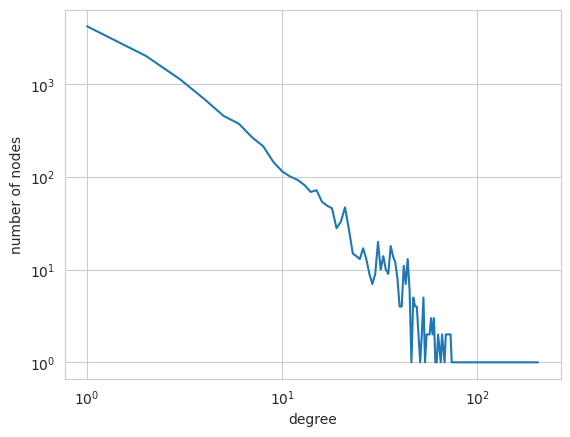

In [13]:
import numpy
dd = sorted(nk.centrality.DegreeCentrality(G).run().scores(), reverse=True)
degrees, numberOfNodes = numpy.unique(dd, return_counts=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes")
plt.plot(degrees, numberOfNodes)
plt.show()

We choose a logarithmic scale on both axes because a _powerlaw degree distribution_, a characteristic feature of complex networks, would show up as a straight line from the top left to the bottom right on such a plot. As we see, the degree distribution of the `PGPgiantcompo` network is definitely skewed, with few high-degree nodes and many low-degree nodes. But does the distribution actually obey a power law? In order to study this, we need to apply the [powerlaw](https://pypi.python.org/pypi/powerlaw) module. Call the following function:

In [14]:
try:
    import powerlaw
    fit = powerlaw.Fit(dd)
except ImportError:
    print ("Module powerlaw could not be loaded")

Calculating best minimal value for power law fit


Fitting xmin:   0%|          | 0/81 [00:00<?, ?it/s]

Fitting xmin:  68%|██████▊   | 55/81 [00:00<00:00, 541.21it/s]

Fitting xmin: 100%|██████████| 81/81 [00:00<00:00, 511.93it/s]

The powerlaw coefficient can then be retrieved via:

In [15]:
try:
    import powerlaw
    fit.alpha
except ImportError:
      print ("Module powerlaw could not be loaded")

If you further want to know how "good" it fits the power law distribution, you can use the the `distribution_compare`-function.

In [16]:
try:
    import powerlaw
    fit.distribution_compare('power_law','exponential')
except ImportError:
      print ("Module powerlaw could not be loaded")

/home/runner/work/networkit/networkit/pyenv/lib/python3.13/site-packages/powerlaw/distributions.py:183: UserWarning: discrete=False but data exclusively contains integer values. Consider using discrete=True.
  warnings.warn('discrete=False but data exclusively contains integer values. Consider using discrete=True.')


## Community Detection

This section demonstrates the community detection capabilities of NetworKit. Community detection is concerned with identifying groups of nodes which are significantly more densely connected to eachother than to the rest of the network.

Code for community detection is contained in the `community` module. The module provides a top-level function to quickly perform community detection with a suitable algorithm and print some stats about the result.

In [17]:
nk.community.detectCommunities(G)

Communities detected in 0.04741 [s]
solution properties:
-------------------  ------------
# communities         104
min community size      6
max community size    677
avg. community size   102.692
imbalance               6.57282
edge cut             1857
edge cut (portion)      0.0763695
modularity              0.88206
-------------------  ------------


The function prints some statistics and returns the partition object representing the communities in the network as an assignment of node to community label. Let's capture this result of the last function call.

In [18]:
communities = nk.community.detectCommunities(G)

Communities detected in 0.03902 [s]
solution properties:
-------------------  ------------
# communities         104
min community size      6
max community size    687
avg. community size   102.692
imbalance               6.6699
edge cut             1835
edge cut (portion)      0.0754647
modularity              0.883422
-------------------  ------------


*Modularity* is the primary measure for the quality of a community detection solution. The value is in the range `[-0.5,1]` and usually depends both on the performance of the algorithm and the presence of distinctive community structures in the network.

In [19]:
nk.community.Modularity().getQuality(communities, G)

0.8834218809621879

### The Partition Data Structure

The result of community detection is a partition of the node set into disjoint subsets. It is represented by the `Partition` data structure, which provides several methods for inspecting and manipulating a partition of a set of elements (which need not be the nodes of a graph).

In [20]:
type(communities)

networkit.structures.Partition

In [21]:
print("{0} elements assigned to {1} subsets".format(communities.numberOfElements(),
                                                    communities.numberOfSubsets()))

10680 elements assigned to 104 subsets


In [22]:
print("the biggest subset has size {0}".format(max(communities.subsetSizes())))

the biggest subset has size 687


The contents of a partition object can be written to file in a simple format, in which each line *i* contains the subset id of node *i*.

In [23]:
nk.community.writeCommunities(communities, "output/communties.partition")

wrote communities to: output/communties.partition


### Choice of Algorithm

The community detection function used a good default choice for an algorithm: *PLM*, our parallel implementation of the well-known Louvain method. It yields a high-quality solution at reasonably fast running times. Let us now apply a variation of this algorithm.

In [24]:
nk.community.detectCommunities(G, algo=nk.community.PLM(G, True))

Communities detected in 0.05974 [s]
solution properties:
-------------------  -----------
# communities         100
min community size      6
max community size    676
avg. community size   106.8
imbalance               6.31776
edge cut             1821
edge cut (portion)      0.074889
modularity              0.883805
-------------------  -----------


We have switched on refinement, and we can see how modularity is slightly improved. For a small network like this, this takes only marginally longer.

### Visualizing the Result

We can easily plot the distribution of community sizes as follows. While the distribution is skewed, it does not seem to fit a power-law, as shown by a log-log plot.

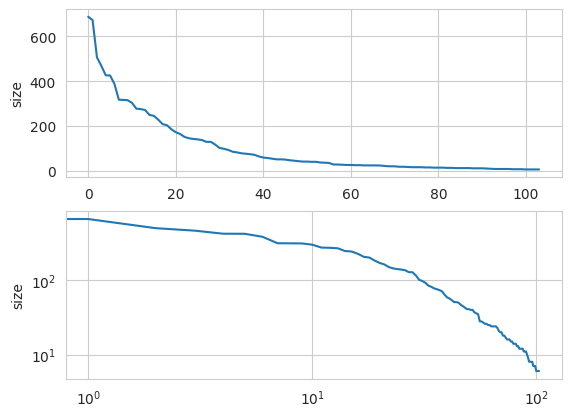

In [25]:
sizes = communities.subsetSizes()
sizes.sort(reverse=True)
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel("size")
ax1.plot(sizes)

ax2 = plt.subplot(2,1,2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel("size")
ax2.plot(sizes)
plt.show()

## Search and Shortest Paths

A simple breadth-first search from a starting node can be performed as follows:

In [26]:
v = 0
bfs = nk.distance.BFS(G, v)
bfs.run()

bfsdist = bfs.getDistances()

The return value is a list of distances from `v` to other nodes - indexed by node id. For example, we can now calculate the mean distance from the starting node to all other nodes:

In [27]:
sum(bfsdist) / len(bfsdist)

11.339044943820225

Similarly, Dijkstra's algorithm yields shortest path distances from a starting node to all other nodes in a weighted graph. Because `PGPgiantcompo` is an unweighted graph, the result is the same here:

In [28]:
dijkstra = nk.distance.Dijkstra(G, v)
dijkstra.run()
spdist = dijkstra.getDistances()
sum(spdist) / len(spdist)

11.339044943820225

## Centrality

[Centrality](http://en.wikipedia.org/wiki/Centrality) measures the relative importance of a node within a graph. Code for centrality analysis is grouped into the `centrality` module.

### Betweenness Centrality

We implement Brandes' algorithm for the exact calculation of betweenness centrality. While the algorithm is efficient, it still needs to calculate shortest paths between all pairs of nodes, so its scalability is limited. We demonstrate it here on the small Karate club graph.  

In [29]:
K = nk.readGraph("../input/karate.graph", nk.Format.METIS)

In [30]:
bc = nk.centrality.Betweenness(K)
bc.run()

We have now calculated centrality values for the given graph, and can retrieve them either as an ordered ranking of nodes or as a list of values indexed by node id. 

In [31]:
bc.ranking()[:10] # the 10 most central nodes

[(0, 462.1428571428572),
 (33, 321.10317460317464),
 (32, 153.38095238095238),
 (2, 151.7015873015873),
 (31, 146.0190476190476),
 (8, 59.058730158730164),
 (1, 56.95714285714285),
 (13, 48.43174603174603),
 (19, 34.29365079365079),
 (5, 31.666666666666664)]

### Approximation of Betweenness

Since exact calculation of betweenness scores is often out of reach, NetworKit provides an approximation algorithm based on path sampling. Here we estimate betweenness centrality in `PGPgiantcompo`, with a probabilistic guarantee that the error is no larger than an additive constant $\epsilon$.

In [32]:
abc = nk.centrality.ApproxBetweenness(G, epsilon=0.1)
abc.run()

The 10 most central nodes according to betweenness are then

In [33]:
abc.ranking()[:10]

[(1143, 0.13116726835138365),
 (6555, 0.10589651022864001),
 (7297, 0.09386281588447641),
 (6655, 0.09265944645006005),
 (6932, 0.08182912154031281),
 (6744, 0.07821901323706373),
 (2258, 0.07581227436823101),
 (6098, 0.07220216606498193),
 (5165, 0.04813477737665466),
 (7369, 0.043321299638989196)]

### Eigenvector Centrality and PageRank

Eigenvector centrality and its variant PageRank assign relative importance to nodes according to their connections, incorporating the idea that edges to high-scoring nodes contribute more. PageRank is a version of eigenvector centrality which introduces a damping factor, modeling a random web surfer which at some point stops following links and jumps to a random page. In PageRank theory, centrality is understood as the probability of such a web surfer to arrive on a certain page. Our implementation of both measures is based on parallel power iteration, a relatively simple eigensolver.

In [34]:
# Eigenvector centrality
ec = nk.centrality.EigenvectorCentrality(K)
ec.run()
ec.ranking()[:10] # the 10 most central nodes

[(33, 0.37335860763538437),
 (0, 0.35548796275763045),
 (2, 0.31719212126079693),
 (32, 0.30864169996172613),
 (1, 0.26595844854862444),
 (8, 0.2274061452435449),
 (13, 0.22647475684342064),
 (3, 0.2111796960531623),
 (31, 0.1910365857249303),
 (30, 0.1747599501690216)]

In [35]:
# PageRank
pr = nk.centrality.PageRank(K, 1e-6)
pr.run()
pr.ranking()[:10] # the 10 most central nodes

[(33, 0.02941190490185556),
 (0, 0.029411888071820155),
 (32, 0.02941184486730034),
 (1, 0.02941180477938106),
 (2, 0.02941179873364914),
 (3, 0.029411771282676906),
 (31, 0.029411770725212477),
 (5, 0.029411768995095993),
 (6, 0.029411768995095993),
 (23, 0.029411763985014328)]

## Core Decomposition

A $k$-core decomposition of a graph is performed by successicely peeling away nodes with degree less than $k$. The remaining nodes form the $k$-core of the graph.

In [36]:
K = nk.readGraph("../input/karate.graph", nk.Format.METIS)
coreDec = nk.centrality.CoreDecomposition(K)
coreDec.run()

Core decomposition assigns a core number to each node, being the maximum $k$ for which a node is contained in the $k$-core. For this small graph, core numbers have the following range:

In [37]:
set(coreDec.scores())

{1.0, 2.0, 3.0, 4.0}

In [38]:
from networkit import vizbridges

nk.vizbridges.widgetFromGraph(K, dimension = nk.vizbridges.Dimension.Two, nodeScores = coreDec.scores())

CytoscapeWidget(cytoscape_layout={'name': 'cose'}, cytoscape_style=[{'selector': 'node', 'css': {'background-c…

## Subgraph

NetworKit supports the creation of Subgraphs depending on an original graph and a set of nodes. This might be useful in case you want to analyze certain communities of a graph. Let's say that community 2 of the above result is of further interest, so we want a new graph that consists of nodes and intra cluster edges of community 2.

In [39]:
c2 = communities.getMembers(2)
g2 = nk.graphtools.subgraphFromNodes(G, c2, compact=True)

In [40]:
communities.subsetSizeMap()[2]

164

In [41]:
g2.numberOfNodes()

164

As we can see, the number of nodes in our subgraph matches the number of nodes of community 2. The subgraph can be used like any other graph object, e.g. further community analysis:

In [42]:
communities2 = nk.community.detectCommunities(g2)

Communities detected in 0.00107 [s]
solution properties:
-------------------  ---------
# communities        11
min community size    4
max community size   30
avg. community size  14.9091
imbalance             2
edge cut             31
edge cut (portion)    0.118321
modularity            0.749891
-------------------  ---------


In [43]:
nk.vizbridges.widgetFromGraph(g2, dimension = nk.vizbridges.Dimension.Two, nodePartition=communities2)

CytoscapeWidget(cytoscape_layout={'name': 'cose'}, cytoscape_style=[{'selector': 'node', 'css': {'background-c…

## NetworkX Compatibility

[NetworkX](https://networkx.org/) is a popular Python package for network analysis. To let both packages complement each other, and to enable the adaptation of existing NetworkX-based code, we support the conversion of the respective graph data structures.

In [44]:
import networkx as nx
nxG = nk.nxadapter.nk2nx(G) # convert from NetworKit.Graph to networkx.Graph
print(nx.degree_assortativity_coefficient(nxG))

0.23821137170816217


## Generating Graphs

An important subfield of network science is the design and analysis of generative models. A variety of generative models have been proposed with the aim of reproducing one or several of the properties we find in real-world complex networks. NetworKit includes generator algorithms for several of them.

The **Erdös-Renyi model** is the most basic random graph model, in which each edge exists with the same uniform probability. NetworKit provides an efficient generator:

In [45]:
ERD = nk.generators.ErdosRenyiGenerator(200, 0.2).generate()
print(ERD.numberOfNodes(), ERD.numberOfEdges())

200 4061


## Transitivity / Clustering Coefficients

In the most general sense, transitivity measures quantify how likely it is that the relations out of which the network is built are transitive. The clustering coefficient is the most prominent of such measures. We need to distinguish between global and local clustering coefficient: The global clustering coefficient for a network gives the fraction of closed triads. The local clustering coefficient focuses on a single node and counts how many of the possible edges between neighbors of the node exist. The average of this value over all nodes is a good indicator for the degreee of transitivity and the presence of community structures in a network, and this is what the following function returns:

In [46]:
nk.globals.clustering(G)

0.4377225744810215

A simple way to generate a **random graph with community structure** is to use the `ClusteredRandomGraphGenerator`. It uses a simple variant of the Erdös-Renyi model: The node set is partitioned into a given number of subsets. Nodes within the same subset have a higher edge probability.

In [47]:
CRG = nk.generators.ClusteredRandomGraphGenerator(200, 4, 0.2, 0.002).generate()
nk.community.detectCommunities(CRG)

Communities detected in 0.00131 [s]
solution properties:
-------------------  ---------
# communities         4
min community size   45
max community size   58
avg. community size  50
imbalance             1.16
edge cut             25
edge cut (portion)    0.023855
modularity            0.716197
-------------------  ---------


The **Chung-Lu model** (also called **configuration model**) generates a random graph which corresponds to a given degree sequence, i.e. has the same expected degree sequence. It can therefore be used to replicate some of the properties of a given real networks, while others are not retained, such as high clustering and the specific community structure.

In [48]:
degreeSequence = [CRG.degree(v) for v in CRG.iterNodes()]
clgen = nk.generators.ChungLuGenerator(degreeSequence)
CLG = clgen.generate()
nk.community.detectCommunities(CLG)

Communities detected in 0.00277 [s]
solution properties:
-------------------  ----------
# communities          9
min community size     1
max community size    35
avg. community size   22.2222
imbalance              1.52174
edge cut             654
edge cut (portion)     0.603878
modularity             0.260553
-------------------  ----------


## Settings

In this section we discuss global settings.

### Logging

When using NetworKit from the command line, the verbosity of console output can be controlled via several loglevels, from least to most verbose: `FATAL`, `ERROR`, `WARN`, `INFO`, `DEBUG` and `TRACE`. (Currently, logging is only available on the console and not visible in the IPython Notebook). 

In [49]:
nk.getLogLevel() # the default loglevel

'ERROR'

In [50]:
nk.setLogLevel("TRACE") # set to most verbose mode
nk.setLogLevel("ERROR") # set back to default

Please note, that the default build setting is optimized (`--optimize=Opt`) and thus, every LOG statement below INFO is removed. If you need DEBUG and TRACE statements, please build the extension module by appending `--optimize=Dbg` when calling the setup script.

### Parallelism

The degree of parallelism can be controlled and monitored in the following way:

In [51]:
nk.setNumberOfThreads(4) # set the maximum number of available threads

In [52]:
nk.getMaxNumberOfThreads() # see maximum number of available threads

4

In [53]:
nk.getCurrentNumberOfThreads() # the number of threads currently executing

1

# Profiling

The [profiling module](https://networkit.github.io/dev-docs/python_api/profiling.html?highlight=profiling#) allows to get an overall picture of a network with a single line of code. Detailed statistics of the main properties of the network are shown both graphically and numerically.

In [54]:
import warnings
warnings.filterwarnings('ignore')
nk.profiling.Profile.create(G).show()

Network Structural Profile 
 
	<!--- HELP --->
 Navigating the profile 
 
 the profile includes the following sections by default: 
 
 global properties 
 overview of node centrality and partition distributions 
 detail views of node centrality distributions 
 node centrality correlations 
 detail views of partitions 
 
 click [+] for descriptions of measures 
 click on distribution thumbnail for detail view 
 hover over variable name of statistical figures for explanation 
 click on distribution plot for larger view 
 
 
	<!--- END HELP --->
 
 10680 
 24316 
 0.000426403 
 False 
 False 
 0 
 (23, 24) 
 N/A 
 1 
 
 
 
 <img src="data:image/svg+xml;utf8,%3Csvg%20xmlns%3Axlink%3D%22http%3A%2F%2Fwww.w3.org%2F1999%2Fxlink%22%20width%3D%22288pt%22%20height%3D%22180pt%22%20viewBox%3D%220%200%20288%20180%22%20xmlns%3D%22http%3A%2F%2Fwww.w3.org%2F2000%2Fsvg%22%20version%3D%221.1%22%3E%20%3Cmetadata%3E%20%3Crdf%3ARDF%20xmlns%3Adc%3D%22http%3A%2F%2Fpurl.org%2Fdc%2Felements%2F1.1%2F%22%20xmlns%3Acc%3D%22http%3A%2F%2Fcreativecommons.org%2Fns%23%22%20xmlns%3Ardf%3D%22http%3A%2F%2Fwww.w3.org%2F1999%2F02%2F22-rdf-syntax-ns%23%22%3E%20%3Ccc%3AWork%3E%20%3Cdc%3Atype%20rdf%3Aresource%3D%22http%3A%2F%2Fpurl.org%2Fdc%2Fdcmitype%2FStillImage%22%2F%3E%20%3Cdc%3Adate%3E2026-02-23T12%3A11%3A04.808498%3C%2Fdc%3Adate%3E%20%3Cdc%3Aformat%3Eimage%2Fsvg%2Bxml%3C%2Fdc%3Aformat%3E%20%3Cdc%3Acreator%3E%20%3Ccc%3AAgent%3E%20%3Cdc%3Atitle%3EMatplotlib%20v3.10.8%2C%20https%3A%2F%2Fmatplotlib.org%2F%3C%2Fdc%3Atitle%3E%20%3C%2Fcc%3AAgent%3E%20%3C%2Fdc%3Acreator%3E%20%3C%2Fcc%3AWork%3E%20%3C%2Frdf%3ARDF%3E%20%3C%2Fmetadata%3E%20%3Cdefs%3E%20%3Cstyle%20type%3D%22text%2Fcss%22%3E%2A%7Bstroke-linejoin%3A%20round%3B%20stroke-linecap%3A%20butt%7D%3C%2Fstyle%3E%20%3C%2Fdefs%3E%20%3Cg%20id%3D%22figure_1%22%3E%20%3Cg%20id%3D%22patch_1%22%3E%20%3Cpath%20d%3D%22M%200%20180%20L%20288%20180%20L%20288%200%20L%200%200%20z%20%22%20style%3D%22fill%3A%20%23ffffff%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22axes_1%22%3E%20%3Cg%20id%3D%22patch_2%22%3E%20%3Cpath%20d%3D%22M%2049.39%20138.04%20L%20263.12%20138.04%20L%20263.12%2012.762328%20L%2049.39%2012.762328%20z%20%22%20style%3D%22fill%3A%20%23ffffff%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22matplotlib.axis_1%22%3E%20%3Cg%20id%3D%22xtick_1%22%3E%20%3Cg%20id%3D%22line2d_1%22%3E%20%3Cpath%20d%3D%22M%2056.335837%20138.04%20L%2056.335837%2012.762328%20%22%20clip-path%3D%22url%28%23p08fa4a1aa7%29%22%20style%3D%22fill%3A%20none%3B%20stroke%3A%20%23d3d3d3%3B%20stroke-width%3A%200.8%3B%20stroke-linecap%3A%20round%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22text_1%22%3E%20%3C%21--%20%24%5Cmathdefault%7B0%7D%24%20--%3E%20%3Cg%20transform%3D%22translate%2853.135837%20152.638438%29%20scale%280.1%20-0.1%29%22%3E%20%3Cdefs%3E%20%3Cpath%20id%3D%22DejaVuSans-30%22%20d%3D%22M%202034%204250%20Q%201547%204250%201301%203770%20Q%201056%203291%201056%202328%20Q%201056%201369%201301%20889%20Q%201547%20409%202034%20409%20Q%202525%20409%202770%20889%20Q%203016%201369%203016%202328%20Q%203016%203291%202770%203770%20Q%202525%204250%202034%204250%20z%20M%202034%204750%20Q%202819%204750%203233%204129%20Q%203647%203509%203647%202328%20Q%203647%201150%203233%20529%20Q%202819%20-91%202034%20-91%20Q%201250%20-91%20836%20529%20Q%20422%201150%20422%202328%20Q%20422%203509%20836%204129%20Q%201250%204750%202034%204750%20z%20%22%20transform%3D%22scale%280.015625%29%22%2F%3E%20%3C%2Fdefs%3E%20%3Cuse%20xlink%3Ahref%3D%22%23DejaVuSans-30%22%20transform%3D%22translate%280%200.78125%29%22%2F%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22xtick_2%22%3E%20%3Cg%20id%3D%22line2d_2%22%3E%20%3Cpath%20d%3D%22M%20104.840285%20138.04%20L%20104.840285%2012.762328%20%22%20clip-path%3D%22url%28%23p08fa4a1aa7%29%22%20style%3D%22fill%3A%20none%3B%20stroke%3A%20%23d3d3d3%3B%20stroke-width%3A%200.8%3B%20stroke-linecap%3A%20round%22%2F%3E%20%3C%2Fg%3E%20%3Cg%20id%3D%22text_2%22%3E%20%3C%21--%20%24%5Cmathdefault%7B50%7D%24%20--%3E%20%3Cg%20transform%3D%22translate%2898.440285%20152.638438%29

## Support

NetworKit is an open-source project that improves with suggestions and contributions from its users. The [mailing list](https://sympa.cms.hu-berlin.de/sympa/subscribe/networkit) is the place for general discussion and questions.